In [1]:
from typing import *
from collections import defaultdict

import graphlib2
import graphlib

from matplotlib import pyplot as plt
import timeit
import igraph
import functools

In [2]:
@functools.cache
def get_linear_graph(n: int) -> Dict[int, List[int]]:
    g = igraph.Graph.Tree(n, 1)
    res: Dict[int, List[int]] = defaultdict(list)
    for source, dest in g.get_edgelist():
        res[source].append(dest)
    return res

@functools.cache
def get_branched_graph(n: int) -> Dict[int, List[int]]:
    g = igraph.Graph.Tree_Game(n, directed=True)
    res: Dict[int, List[int]] = defaultdict(list)
    for source, dest in g.get_edgelist():
        res[source].append(dest)
    return res

In [3]:
def run(t) -> None:
    to_remove = t.get_ready()
    while t.is_active():
        t.done(*to_remove)
        to_remove = t.get_ready()



def setup_rust(n: int, graph_gen: Callable[[int], Dict[int, List[int]]]):
    t = graphlib2.TopologicalSorter(graph_gen(n))
    t.prepare()
    return t


def setup_python(n: int, graph_gen: Callable[[int], Dict[int, List[int]]]):
    t = graphlib.TopologicalSorter(graph_gen(n))
    t.prepare()
    return t

In [4]:
glbls = {
    "setup_python": setup_python,
    "setup_rust": setup_rust,
    "run": run,
    "get_linear_graph": get_linear_graph,
    "get_branched_graph": get_branched_graph,
}



def plot(upper: int, samples: int, graph_factory: str, lower: int = 0, loops: int = 10) -> None:
    samples = min(samples, upper-lower)
    x = [round(lower + x*(upper-lower)/samples) for x in range(samples)]
    y_python: List[float] = []
    y_rust: List[float] = []

    for n in x:
        # Time Python and get the # of loops and match that
        timerpy = timeit.Timer(stmt=f"run(t)", setup=f"t = setup_python({n}, {graph_factory})", globals=glbls)
        pytime = timerpy.repeat(loops, number=1)
        y_python.append(min(pytime))
        timerust = timeit.Timer(stmt=f"run(t)", setup=f"t = setup_rust({n}, {graph_factory})", globals=glbls)
        rustime = timerust.repeat(loops, number=1)
        y_rust.append(min(rustime))
    plt.plot(x, y_python, label="python")
    plt.plot(x, y_rust, label="rust")
    plt.legend(loc="upper left")
    plt.xlabel("V (number of vertices)")
    plt.ylabel("Execution time (s)")

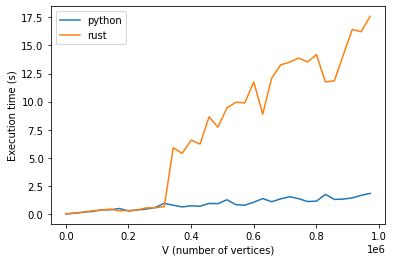

In [5]:
plot(upper=1_000_000, samples=35, loops=1, graph_factory="get_linear_graph")

In [6]:
plot(upper=1_000_000, samples=35, loops=1, graph_factory="get_branched_graph")

KeyboardInterrupt: 

In [ ]:
g = get_branched_graph(1_000_000)
t = graphlib2.TopologicalSorter(g)
t.prepare()

In [ ]:
%%timeit
t.copy()

323 ms ± 8.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
g.copy()

15.5 ms ± 85.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
